# Exploiting all the methods tried so far

In [1]:
#utils
import emoji, re, string, time, os
from utils import get_test_metrics
from utils import preprocess
from utils import get_user_features, get_top_users
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
def optimal_threshold(prob,y):
    best_thresold = 0
    best_score = 0
    
    for i in range(100):
        threshold = i/100
        y_pred = [1 if p >= threshold else 0 for p in prob]
        score = metrics.accuracy_score(y,y_pred)
        
        if score > best_score:
            #print(score)
            best_thresold = threshold
            best_score = score
            
    return best_thresold

# optimal mlp for tfidf
def get_mlp():
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 5, max_iter = 100,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
    return clf

# tunning hyperparameters mlp
n_iter = 10
def random_layers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(1,15)*25
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

def random_search_mlp(X_train,y_train,n_iter=10):
    
    # hyperparams to optimize
    hidden_layers = []
    alphas = []
    batch_sizes = []
    learning_rate_inits = []
    # sample
    np.random.seed(0)
    for i in range(n_iter):   
        hl = random_layers()
        #print(hl,end = '; ')
        hidden_layers.append(hl)
        ap = 10**np.random.uniform(-6,-2)
        #print(ap, end = '; ')
        alphas.append(ap)
        learning = 10**np.random.uniform(-4,-1)
        #print(learning, end = '; ')
        learning_rate_inits.append(learning)
        batch = np.random.randint(1,7)*50 #math.floor(10**np.random.uniform(1.5,2.6)) #np.random.randint(2,30)*10
        #print(batch)
        batch_sizes.append(batch)

    # tunning
    X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    best_score = 0
    i = 0
    for hl,bs,al,lri in zip(hidden_layers,batch_sizes,alphas,learning_rate_inits):
        
        clf = optimized_mlp(hl,bs,al,lri)

        print(i, end= ' ')
        i+=1
        print()
        print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))    
        clf.fit(X_train_v, y_train_v)
        y_pred = clf.predict(X_val)        
        y_prob = clf.predict_proba(X_val)[:,1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        print('AUC: {a:.3f}'.format(a=roc_auc))       
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = (hl,bs,al,lri)

        #print('validation rmse: {a:.3f}'.format(a=rmse))


    hl,bs,al,lri = best_params
    print()
    print('--------------------')
    print('BEST PARAMETERS (validation AUC = {a:.3f})'.format(a=best_score))
    print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))
    print('--------------------')
    return hl,bs,al,lri

def optimized_mlp(hl,bs,al,lri):
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 100,
                   hidden_layer_sizes = hl, alpha = al, 
                   learning_rate_init = lri, batch_size = bs)
    return clf

def train_test(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)
    return test_metrics
    


# Load data

In [3]:
# messages
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)

#removing duplicates and selecting only labelled data
df = df.drop_duplicates(subset=['text'])
df = df[df['midia']==0]
df['viral'] = [1 if mis==1 else vir for mis,vir in zip(df['misinformation'],df['viral'])]
df = df[df['viral']==1]

df.reset_index(drop=True,inplace=True)

df.head()

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,characters,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma,timestamp
0,6942577183305588053,02/07/18,10:46,55,BRASIL,BRA,91,Pará,2018_10,0,...,4099,634,1,1,"O dia em que ex-guerrilheiro, militantes e des...",1,"dia ex - guerrilheiro , militantes desarmament...","dia ex - guerrilh , milit desarmament tent ""fu...","dia ex - guerrilheiro , militante desarmamenti...",2018-07-02 10:46:00
1,-2072140886659020977,02/07/18,10:50,55,BRASIL,BRA,67,Mato Grosso do Sul,2018_14,0,...,247,40,1,3,O nível dos jornalistas do programa Roda Viva ...,1,nivel jornalistas programa roda viva tao baixo...,nivel jornal program rod viv tao baix ate marc...,nivel jornalista programarr rodar vivo tao bai...,2018-07-02 10:50:00
2,-5100443702615645928,02/07/18,11:03,55,BRASIL,BRA,21,Rio de Janeiro,2018_59,0,...,1192,164,1,2,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,* atencao * \n \n precisamos ajuda todos voces...,* atenca * \n \n precis ajud tod voc * mant av...,* atencao * \n \n precisar ajudar todo voces *...,2018-07-02 11:03:00
3,-1561843698204261697,02/07/18,16:31,55,BRASIL,BRA,63,Tocantins,2018_56,0,...,177,31,1,5,"Gestão do colombiano na capital, imagina ele n...",1,"gestao colombiano capital , imagina governo , ...","gesta colombi capit , imagin govern , grac deu...","gestao colombiano capital , imaginar governar ...",2018-07-02 16:31:00
4,-5876784761398352499,02/07/18,18:09,55,BRASIL,BRA,61,Distrito Federal,2018_20,0,...,122,17,1,2,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,🛑 🛑 🛑 🛑 🛑 🛑 \n interrompendo momentaneamente c...,"🛑 🛑 🛑 🛑 🛑 🛑 \n interromp momentane convers , n...",🛑 🛑 🛑 🛑 🛑 🛑 \n interromper momentaneamente con...,2018-07-02 18:09:00


In [4]:
# select data

#texts
original_texts = df['text']
texts = df['preprocessed_text_lemma']
#target
y = df['misinformation']

# cut index
cut = math.floor(len(df)*0.8)
cut

5109

data balance in dataset


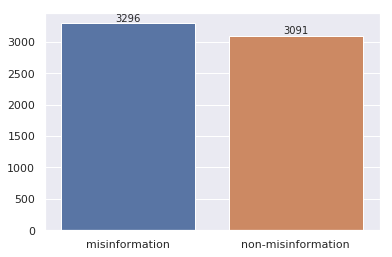

In [5]:
def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
print('data balance in dataset')        
print_class_balance(y)

# Train-test split

train
test


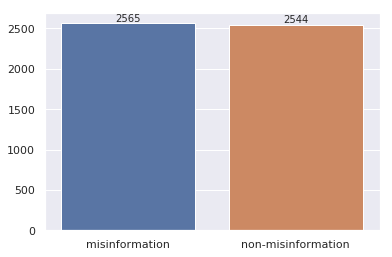

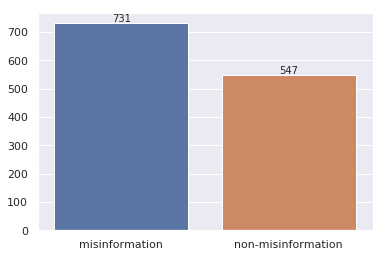

In [6]:
# use only characters
# texts = df['text']
# texts = [' '.join(list(t)) for t in texts]

# train with the 80% older messages; test with the 20% newer
# split by time

X_train_texts = texts[0:cut]
y_train= y[0:cut]
X_test_texts = texts[cut:]
y_test = y[cut:]

X_train_og_texts = original_texts[0:cut]
X_test_og_texts = original_texts[cut:]


print('train')
print_class_balance(y_train)
plt.figure()
print('test')
print_class_balance(y_test)

In [62]:
print('samples train')
pos_mask = y_train == 1 
mis = X_train_og_texts[pos_mask]
neg_mask = y_train == 0 
non_mis = X_train_og_texts[neg_mask]
sample = list(mis.sample(1))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
sample = list(non_mis.sample(1))
print('---------------------------------------')
print('non misinformation')
for m in sample:
    print('*********')
    print(m)
    print()

samples train

misinformation
*********
MENSAGEM DO PADRE Carlos Maria De Aguiar

Bolsonaro não precisa mais sair à ruas para fazer campanha.

Hoje, em Juiz de Fora, ele foi o vencedor.

Não precisa mais andar pelos aeroportos, avenidas e rincões do Brasil.

Não precisa mais ser carregado nas costas pelos seus correligionários e eleitores: ele mostrou que o Brasil precisa de heróis!

Ele derramou seu sangue pela Pátria.

Sua dor, sua aflição e seu sofrimento enalteceram sua candidatura e sua estatura como homem e como líder.

E mostrou que um simples homem honesto pode aterrorizar quem odeia os valores cristãos e prefere o caos.

Bolsonaro hoje venceu as eleições com um mês de antecedência.

Às vésperas da celebração da nossa Independência ele libertou o Brasil da dúvida, das amarras e da escravidão ideológica.

Ele hoje provou que tinha razão.

Ele demonstrou que falava a verdade, mesmo à custa de seu sangue.

Ele uniu o Brasil em volta de seu sonho e do seu projeto.

Ele apontou para

In [63]:
print('samples test')
pos_mask = y_test == 1 
mis = X_test_og_texts[pos_mask]
neg_mask = y_test == 0 
non_mis = X_test_og_texts[neg_mask]
sample = list(mis.sample(1))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
sample = list(non_mis.sample(1))
print('---------------------------------------')
print('non misinformation')
for m in sample:
    print('*********')
    print(m)
    print()

samples test

misinformation
*********
🇧🇷 *ALERTA MÁXIMO* 🇧🇷

Não resta nenhuma dúvida de que a real aceitação popular ao  Bolsonaro está na casa de 70% do eleitorado brasileiro, eleitores estes que jamais mudariam seu voto às vésperas, arrastados por enganação de pesquisas falsas, até porque a rejeição ao comunismo já é total e irreversível. 

Agora, onde andam as reais autoridades deste país para aceitarem caladas mais uma atuação fraudulenta a caminho das urnas do 2.o turno, manipuladas pelo sistema?

Vejamos só o que trarão os institutos nesta última semana... Queda do Bolsonaro e alavancada do Haddad pela consumação diabólica. Isso sim é um *VERDADEIRO ATENTADO CONTRA A DEMOCRACIA*. 

Unamo-nos todos, empresários, caminhoneiros, religiosos, famílias, intervencionistas... pela salvação da Pátria. 

Jamais desistamos! Brasil acima de tudo, Deus acima de todos.

😏👉🏼👉🏼1⃣7⃣

---------------------------------------
non misinformation
*********
"Tem que fechar o Supremo Tribunal Federal"

# BoW

In [18]:
#vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)
vectorizer.fit(X_train_texts)   
X_train = vectorizer.transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)
X_train.shape

(5109, 316272)

In [23]:
print(vectorizer.get_feature_names()[100:150])

['! ! estao', '! ! estar', '! ! evitar', '! ! exigir', '! ! facam', '! ! falir', '! ! familia', '! ! faomos', '! ! farar', '! ! farlei', '! ! fato', '! ! favor', '! ! fazer', '! ! feliz', '! ! fernando', '! ! ficar', '! ! ficor', '! ! filhar', '! ! fiscal', '! ! focar', '! ! foraaaaaa', '! ! forcar', '! ! fraudar', '! ! froudor', '! ! futurar', '! ! gang', '! ! ganhar', '! ! general', '! ! gente', '! ! gloriar', '! ! gracas', '! ! grande', '! ! grupar', '! ! haddad', '! ! hanna', '! ! hoje', '! ! homem', '! ! homenagem', '! ! incluir', '! ! incrivel', '! ! investir', '! ! ir', '! ! ja', '! ! jipeiros', '! ! jogar', '! ! jovem', '! ! jurista', '! ! kkk', '! ! l', '! ! ler']


logistic regression + tf-idf
0.42
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       547
           1       0.84      0.74      0.79       731

    accuracy                           0.77      1278
   macro avg       0.77      0.77      0.77      1278
weighted avg       0.78      0.77      0.77      1278

AUC:  0.8552782619786573


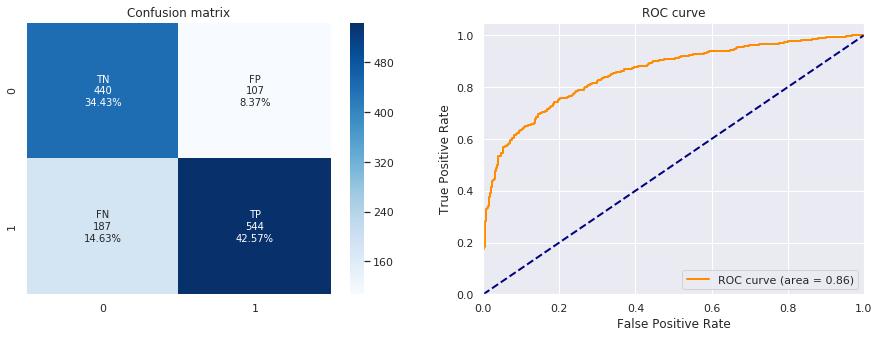

(0.7699530516431925,
 0.8356374807987711,
 0.7495741056218058,
 0.7441860465116279,
 0.7495741056218058,
 0.7872648335745297,
 0.7495741056218058,
 0.8552782619786573)

In [39]:
print('logistic regression + binary bow')
clf = LogisticRegression()
clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

#thr = optimal_threshold(y_prob,y_test)
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + bow
Iteration 1, loss = 0.56044297
Validation score: 0.808219
Iteration 2, loss = 0.35119918
Validation score: 0.839530
Iteration 3, loss = 0.22609303
Validation score: 0.833659
Iteration 4, loss = 0.15711581
Validation score: 0.841487
Iteration 5, loss = 0.11318160
Validation score: 0.841487
Iteration 6, loss = 0.08719319
Validation score: 0.839530
Iteration 7, loss = 0.06731425
Validation score: 0.841487
Iteration 8, loss = 0.05650352
Validation score: 0.839530
Validation score did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
              precision    recall  f1-score   support

           0       0.64      0.89      0.75       547
           1       0.88      0.63      0.73       731

    accuracy                           0.74      1278
   macro avg       0.76      0.76      0.74      1278
weighted avg       0.78      0.74      0.74      1278

AUC:  0.8326126590256016


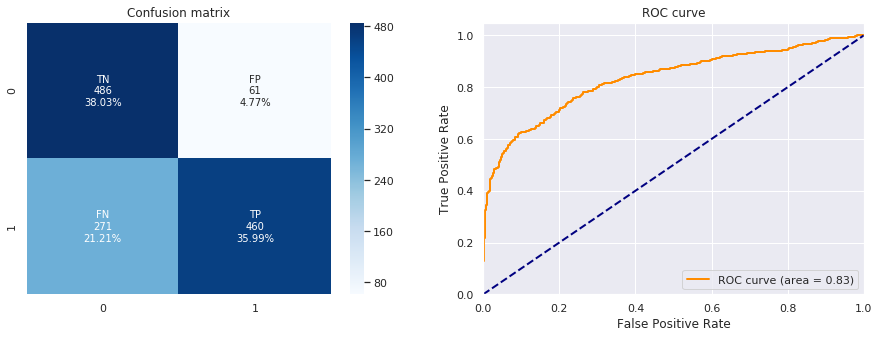

In [24]:
print('mlp + bow')
clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 20,
                   hidden_layer_sizes = (100,), alpha = .00001, 
                   learning_rate_init = .0001, batch_size = 32)
results = train_test(clf,X_train,X_test,y_train,y_test)

# Topic modelling (LDA)

In [46]:
# topics
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
n_topics = 15

def train_lda(corpus, n_topics = 100):
    common_texts = [x.split() for x in corpus]
    common_dictionary = Dictionary(common_texts)
    common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
    lda = LdaModel(common_corpus, num_topics=n_topics)
    return lda, common_dictionary

lda, common_dictionary = train_lda(X_train_texts, n_topics)

In [47]:
# vectorizing
def tup2array(tuples,n_topics):
    topics = np.zeros(n_topics)
    for t, p in tuples:
        topics[t] = p
    return topics

def vectorize_topics(X,lda):
    X = [lda[x] for x in X]
    X = [tup2array(v,lda.num_topics) for v in X]
    return X

def texts2topics(texts,lda):
    X = [x.split() for x in texts]
    X = [common_dictionary.doc2bow(text) for text in X]
    X = vectorize_topics(X,lda)
    return X
    

X_train_topics = texts2topics(X_train_texts,lda)
X_test_topics = texts2topics(X_test_texts,lda)

logistic regression + lda
0.38
              precision    recall  f1-score   support

           0       0.62      0.15      0.24       547
           1       0.59      0.93      0.72       731

    accuracy                           0.60      1278
   macro avg       0.61      0.54      0.48      1278
weighted avg       0.60      0.60      0.52      1278

AUC:  0.5930820268245898


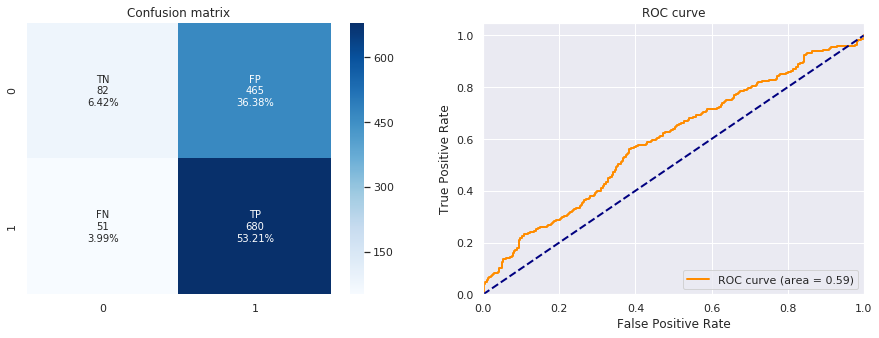

In [28]:
print('logistic regression + lda')
clf = LogisticRegression()
clf.fit(X_train_topics,y_train)
y_prob = clf.predict_proba(X_test_topics)[:,1]
thr = optimal_threshold(y_prob,y_test)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + lda
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 200
AUC: 0.599
1 
hidden layers: (100, 150); alpha: 0.00003; learning rate: 0.00078; batch: 50
AUC: 0.604
2 
hidden layers: (325,); alpha: 0.00003; learning rate: 0.02372; batch: 200
AUC: 0.609
3 
hidden layers: (225, 50, 150); alpha: 0.00221; learning rate: 0.00103; batch: 50
AUC: 0.600
4 
hidden layers: (100,); alpha: 0.00674; learning rate: 0.00026; batch: 50
AUC: 0.592
5 
hidden layers: (100, 225, 50); alpha: 0.00007; learning rate: 0.02196; batch: 150
AUC: 0.609
6 
hidden layers: (50,); alpha: 0.00000; learning rate: 0.06823; batch: 200
AUC: 0.598
7 
hidden layers: (125, 200, 100); alpha: 0.00001; learning rate: 0.01625; batch: 50
AUC: 0.604
8 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 50
AUC: 0.599
9 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.634

--------------------
BEST PARAMETERS (validation AUC = 0.634)
hidden layers

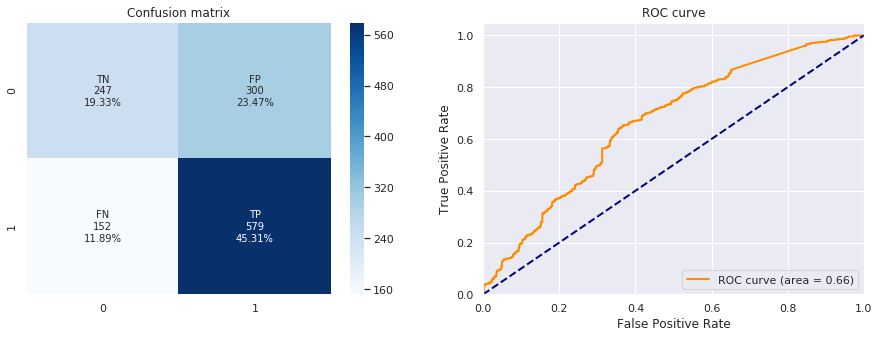

In [29]:
print('mlp + lda')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train_topics,y_train)
y_prob = clf.predict_proba(X_test_topics)[:,1]
thr = optimal_threshold(y_prob,y_test)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Contextual features
* How many times the message was shared
* How many people have seen it
* How many groups
* Features from users that shared the message / credibility
* Spreading velocity

# Combine with other viral messages sent by users
**Ideias**
* get the last texts from the user who sent the message
* get all viral texts sent by all users
* use unique texts or count the repeated?
* weight the words from principal message
* count number of times that each user posted the messages

In [88]:
df

,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,characters,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma,timestamp
0,6942577183305588053,02/07/18,10:46,55,BRASIL,BRA,91,Pará,2018_10,0,...,4099,634,1,1,"O dia em que ex-guerrilheiro, militantes e des...",1,"dia ex - guerrilheiro , militantes desarmament...","dia ex - guerrilh , milit desarmament tent ""fu...","dia ex - guerrilheiro , militante desarmamenti...",2018-07-02 10:46:00
1,-2072140886659020977,02/07/18,10:50,55,BRASIL,BRA,67,Mato Grosso do Sul,2018_14,0,...,247,40,1,3,O nível dos jornalistas do programa Roda Viva ...,1,nivel jornalistas programa roda viva tao baixo...,nivel jornal program rod viv tao baix ate marc...,nivel jornalista programarr rodar vivo tao bai...,2018-07-02 10:50:00
2,-5100443702615645928,02/07/18,11:03,55,BRASIL,BRA,21,Rio de Janeiro,2018_59,0,...,1192,164,1,2,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,* atencao * \n \n precisamos ajuda todos voces...,* atenca * \n \n precis ajud tod voc * mant av...,* atencao * \n \n precisar ajudar todo voces *...,2018-07-02 11:03:00
3,-1561843698204261697,02/07/18,16:31,55,BRASIL,BRA,63,Tocantins,2018_56,0,...,177,31,1,5,"Gestão do colombiano na capital, imagina ele n...",1,"gestao colombiano capital , imagina governo , ...","gesta colombi capit , imagin govern , grac deu...","gestao colombiano capital , imaginar governar ...",2018-07-02 16:31:00
4,-5876784761398352499,02/07/18,18:09,55,BRASIL,BRA,61,Distrito Federal,2018_20,0,...,122,17,1,2,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,🛑 🛑 🛑 🛑 🛑 🛑 \n interrompendo momentaneamente c...,"🛑 🛑 🛑 🛑 🛑 🛑 \n interromp momentane convers , n...",🛑 🛑 🛑 🛑 🛑 🛑 \n interromper momentaneamente con...,2018-07-02 18:09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6382,6237256410123034833,28/10/18,21:05,55,BRASIL,BRA,73,Bahia,2018_44,0,...,71,9,1,1,🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷BBBBBBAAAASSSSSLLLL #B17 17 #B...,1,🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 bbbbbbaaaassss...,🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 bbbbbbaaaassss...,🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 🇧 🇷 bbbbbbaaaassss...,2018-10-28 21:05:00
6383,2485357201479715834,28/10/18,21:53,55,BRASIL,BRA,62,Goiás,2018_56,0,...,1250,161,1,1,OLHA O QUANTO AVANÇAMOS! SE LIGA NESSA LIMPEZA...,1,olha quanto avancamos ! liga nessa limpeza ! e...,olh quant avanc ! lig ness limp ! esta : \n \n...,olhar quantum avancamos ! ligar nessa limpeza ...,2018-10-28 21:53:00
6384,657760642306071754,28/10/18,22:19,55,BRASIL,BRA,63,Tocantins,2018_8,0,...,68,12,1,2,Alguem tirou fotos do boletim de urna? Podem ...,1,alguem tirou fotos boletim urna ? podem enviar...,algu tir fot boletim urn ? pod envi mim ? grat,alguem tirar foto boletim urna ? poder enviar ...,2018-10-28 22:19:00
6385,3795679520023557695,28/10/18,22:25,55,BRASIL,BRA,62,Goiás,2018_44,0,...,49,8,1,2,Em frente a polícia federal... Dormitório do Lula,0,frente policia federal . . . dormitorio lula,frent polic feder . . . dormitori lul,frente policiar federal . . . dormitorio lula,2018-10-28 22:25:00


In [30]:
def combine_texts(list_texts,X_train_texts,constant=5):
    
    combined_texts_train = []
    
    for text in list_texts:
        
        if len(text.split()) >= 50:
            combined_texts_train.append(text)
            continue
            
        users = df[df['preprocessed_text_lemma']==text]['id'].unique()
        viral_texts = []
        for user in users:
            viral_texts_user = df[df['id']==user]['preprocessed_text_lemma'].unique() #use only unique texts
            viral_texts_user = list(viral_texts_user)
            # use only texts in train set
            viral_texts_user = [t for t in viral_texts_user if t in X_train_texts]
            if viral_texts_user:
                viral_texts.append(viral_texts_user)

        # discard repeated texts
        if not viral_texts:
            viral_texts = ''

        viral_texts = set(viral_texts)
        viral_texts.discard(text)

        # weight message        
        weighted = [text]*(constant) # or use constant: 5 *len(users)+

        # join texts
        combined = weighted + list(viral_texts)
        combined = ' '.join(combined)
        combined_texts_train.append(combined)
    return combined_texts_train
    
    

In [31]:
combined_texts_train = combine_texts(X_train_texts,X_train_texts,20)
combined_texts_test = combine_texts(X_test_texts,X_train_texts,20)

In [35]:
# vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), 
#                              lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+')
vectorizer.fit(combined_texts_train)   
X_train = vectorizer.transform(combined_texts_train)
X_test = vectorizer.transform(combined_texts_test)
X_train.shape

(5109, 322938)

In [36]:
print('logistic regression + tf-idf')
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]

logistic regression + tf-idf


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.23
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       547
           1       0.73      0.82      0.77       731

    accuracy                           0.72      1278
   macro avg       0.72      0.70      0.71      1278
weighted avg       0.72      0.72      0.71      1278

AUC:  0.761342179829289


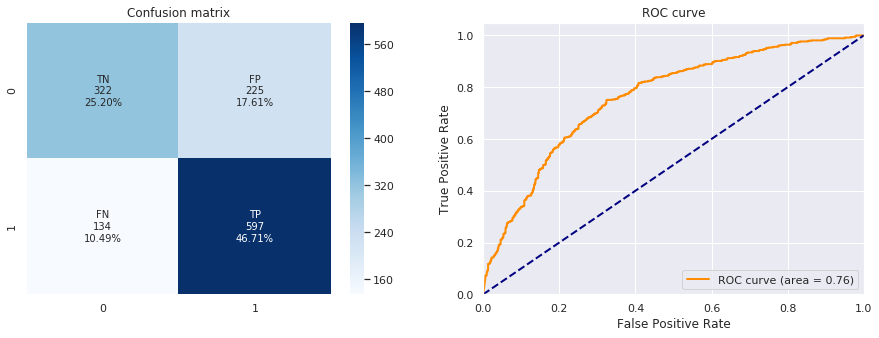

(0.7190923317683882,
 0.7262773722627737,
 0.642073778664008,
 0.8166894664842681,
 0.642073778664008,
 0.7688345138441725,
 0.642073778664008,
 0.761342179829289)

In [37]:
# threshold moving
thr = optimal_threshold(y_prob,y_test)    
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

Iteration 1, loss = 0.68473253
Validation score: 0.534247
Iteration 2, loss = 0.63156504
Validation score: 0.671233
Iteration 3, loss = 0.56036169
Validation score: 0.804305
Iteration 4, loss = 0.49052290
Validation score: 0.804305
Iteration 5, loss = 0.42751253
Validation score: 0.812133
Iteration 6, loss = 0.37192068
Validation score: 0.810176
Iteration 7, loss = 0.32365356
Validation score: 0.812133
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       547
           1       0.76      0.70      0.73       731

    accuracy                           0.70      1278
   macro avg       0.70      0.70      0.70      1278
weighted avg       0.71      0.70      0.70      1278

AUC:  0.7955444071255473


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


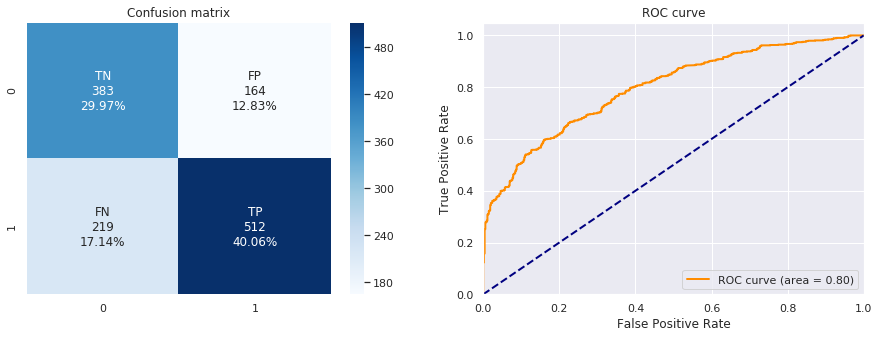

In [150]:
clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 7,
                   hidden_layer_sizes = (100,), alpha = .00001, 
                   learning_rate_init = .0001, batch_size = 32)
results = train_test(clf,X_train,X_test,y_train,y_test)

# Word embeddings

In [7]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


In [11]:
class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print("W2V: Epoch #{}".format(self.epoch))
        
epoch_logger = EpochLogger()
w2v = Word2Vec.load("data/2018/word2vec.model")

In [12]:
def vectorize_text(model, text, method='mean'):
        """
        Convert all words in a text to their embedding vector
        and calculate a vector for the text, by the mean or the sum of word vectors
        Parameters
        ----------
        text: str
        Text from wich the word vector's will be calculated    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        vec: numpy.ndarray 
        Array of the word embeddings from the given text 
        """
        n = model.vector_size
        X = np.empty(shape=[0, n])
        words = text.split()
        for word in words:
            try:
                vec = model[word]
                X = np.append(X,[vec], axis = 0)
            # if oov:    
            except:
                #print('word not in vocabulary: ', word)
                continue
        if X.size == 0:
            vec = np.zeros(n)
        elif method == 'mean':
            vec = np.mean(X,axis=0)
        elif method == 'sum':
            vec = np.sum(X,axis=0)
        return vec
    
def vectorize_corpus(model, corpus, method='mean'):
        """
        Convert all texts in a corpus to vectors
        Parameters
        ----------
        corpus: list
        List of texts    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        X: numpy.ndarray 
        2D Array of vectors from each text in corpus
        """
        X = [vectorize_text(model, text, method=method) for text in corpus]
        X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
        return X

x = vectorize_corpus(w2v, 'bolsonaro é um prego')
x

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


array([[ 4.50450706, -1.06027102, -2.48043728, ...,  1.57965744,
        -2.30190659,  2.72063661],
       [-5.27072716, -2.30779886,  1.51520276, ..., -4.02554893,
         2.9138999 , -7.73963451],
       [ 6.27606964, -1.47590303, -0.94651538, ..., -1.8887347 ,
         2.77219248, -2.39111567],
       ...,
       [-4.29566669, -4.81553888,  1.82514572, ...,  2.06159592,
        -1.26361191,  6.5549159 ],
       [-0.37181717, -7.11151743, -2.28299499, ..., -9.74052715,
         5.951859  , -0.02190241],
       [-5.27072716, -2.30779886,  1.51520276, ..., -4.02554893,
         2.9138999 , -7.73963451]])

In [13]:
X_train = vectorize_corpus(w2v,X_train_texts)
X_test = vectorize_corpus(w2v,X_test_texts)

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


logistic regression + w2v
0.39
              precision    recall  f1-score   support

           0       0.68      0.51      0.58       547
           1       0.69      0.82      0.75       731

    accuracy                           0.69      1278
   macro avg       0.68      0.66      0.66      1278
weighted avg       0.68      0.69      0.68      1278

AUC:  0.7098762807703755


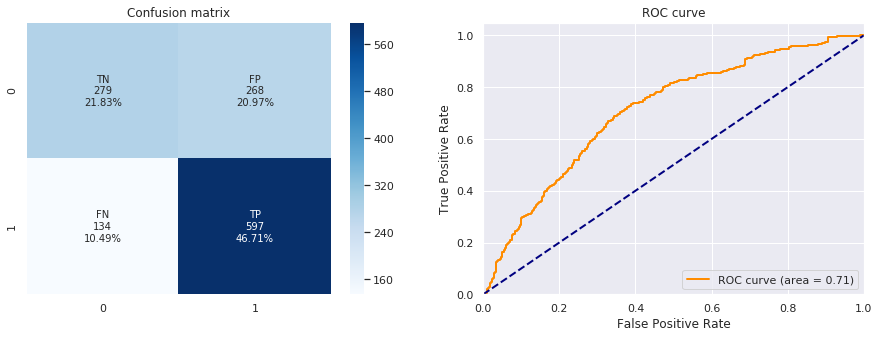

In [14]:
print('logistic regression + w2v')
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:,1]
thr = optimal_threshold(y_prob,y_test)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 200
AUC: 0.814
1 
hidden layers: (100, 150); alpha: 0.00003; learning rate: 0.00078; batch: 50
AUC: 0.834
2 
hidden layers: (325,); alpha: 0.00003; learning rate: 0.02372; batch: 200
AUC: 0.823
3 
hidden layers: (225, 50, 150); alpha: 0.00221; learning rate: 0.00103; batch: 50
AUC: 0.860
4 
hidden layers: (100,); alpha: 0.00674; learning rate: 0.00026; batch: 50
AUC: 0.820
5 
hidden layers: (100, 225, 50); alpha: 0.00007; learning rate: 0.02196; batch: 150
AUC: 0.833
6 
hidden layers: (50,); alpha: 0.00000; learning rate: 0.06823; batch: 200
AUC: 0.795
7 
hidden layers: (125, 200, 100); alpha: 0.00001; learning rate: 0.01625; batch: 50
AUC: 0.831
8 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 50
AUC: 0.844
9 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.841
10 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch

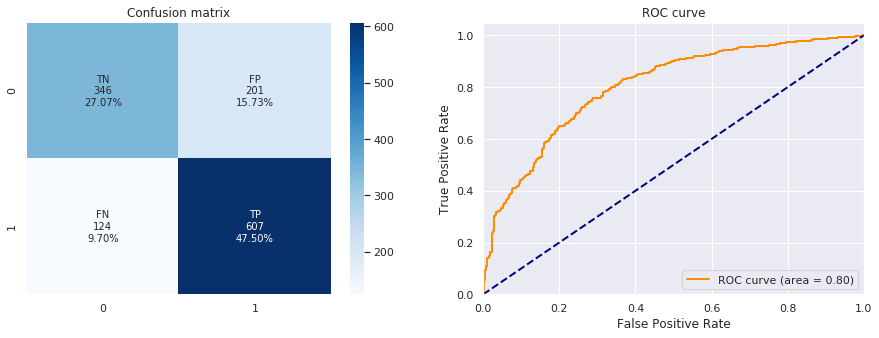

In [15]:
print('mlp + w2v')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=50)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
thr = optimal_threshold(y_prob,y_test)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)